# **Visual Sound Detection Model**

This notebook builds a computer vision classifier that learns from images located in the `images` folder. Each image file name is interpreted as its label. The pipeline covers environment setup, data ingestion, preprocessing, model training, evaluation, and an optional realtime webcam inference demo.

> **Note:** Add your images to `images/` before running the training steps. The notebook assumes a standard RGB image format (e.g., `.jpg`, `.png`).


In [1]:
import os
import sys
import math
import json
from pathlib import Path
from typing import Callable, Dict, List, Tuple

import numpy as np
import pandas as pd
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns

# Optional: used later for webcam capture
try:
    import cv2
except ImportError:
    cv2 = None
    print("OpenCV (cv2) not found. Webcam inference cell will guide you through installing it.")

# Configure paths
PROJECT_ROOT = Path("/Users/raoabdul/Documents/Development/NextGen-Innovators/Ml Model")
IMAGE_DIR = PROJECT_ROOT / "images"
ARTIFACT_DIR = PROJECT_ROOT / "artifacts"
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

# Basic reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"TensorFlow version: {tf.__version__}")
print(f"Looking for images in: {IMAGE_DIR}")


TensorFlow version: 2.20.0
Looking for images in: /Users/raoabdul/Documents/Development/NextGen-Innovators/Ml Model/images


## **1. Dataset Discovery & Label Parsing**

This section scans the `images` directory, extracts labels from file names, and builds a dataframe describing the dataset. Customize `extract_label_from_name` if you prefer a different naming convention.


In [12]:
def extract_label_from_name(filename: str) -> str:
    """Derive a label from the image filename (without the extension).

    Strategy:
      1. Remove the file extension.
      2. Split on underscores, dashes, or spaces.
      3. Use the first token as the class name.

    Adjust this heuristic to match your naming scheme.
    """
    stem = Path(filename).stem
    for delimiter in ("_", "-", " "):
        if delimiter in stem:
            return stem.split(delimiter)[0].lower()
    return stem.lower()


def discover_dataset(image_dir: Path) -> pd.DataFrame:
    """Return a dataframe with columns [path, label]."""
    image_paths = sorted(
        p for p in image_dir.glob("**/*") if p.is_file() and p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp"}
    )
    if not image_paths:
        raise FileNotFoundError(
            f"No images found in {image_dir}. Add files before running training."
        )
    records = []
    for path in image_paths:
        label = extract_label_from_name(path.name)
        records.append({"path": path, "label": label})
    df = pd.DataFrame(records)
    return df


def summarize_dataset(df: pd.DataFrame) -> None:
    """Print summary statistics and plot label distribution."""
    print(f"Total images: {len(df)}")
    label_counts = df["label"].value_counts().sort_values(ascending=False)
    print("\nLabel distribution:")
    print(label_counts)

    plt.figure(figsize=(10, 4))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.title("Image count per label")
    plt.tight_layout()
    plt.show()


def train_val_test_split(
    df: pd.DataFrame,
    train_frac: float = 0.7,
    val_frac: float = 0.2,
    test_frac: float = 0.1,
    seed: int = 42,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:

    """
    Split the dataframe into train/validation/test subsets stratified by label.
    For very small datasets (<20 images total), adjusts splits automatically.
    """
    if not math.isclose(train_frac + val_frac + test_frac, 1.0, rel_tol=1e-5):
        raise ValueError("train_frac + val_frac + test_frac must sum to 1.0")

    total_images = len(df)
    num_classes = len(df["label"].unique())
    images_per_class = total_images // num_classes if num_classes > 0 else 0

    # Adjust splits for very small datasets
    if total_images <= 20:
        # For very small datasets, use larger train split, skip test if too small
        train_frac = 0.75
        val_frac = 0.15
        test_frac = 0.10
        print(f"⚠️  Very small dataset detected ({total_images} images). Using adjusted splits: 75% train, 15% val, 10% test")

    df_shuffled = df.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    splits: Dict[str, List[pd.Series]] = {"train": [], "val": [], "test": []}

    for label, group in df_shuffled.groupby("label"):
        n = len(group)
        n_train = max(1, int(n * train_frac))
        n_val = max(1, int(n * val_frac)) if n >= 3 and val_frac > 0 else 0
        n_test = n - n_train - n_val if test_frac > 0 else 0
        splits["train"].append(group.iloc[:n_train])
        if n_val > 0:
            splits["val"].append(group.iloc[n_train : n_train + n_val])
        if n_test > 0:
            splits["test"].append(group.iloc[n_train + n_val :])

    train_df = pd.concat(splits["train"]).reset_index(drop=True)
    val_df = pd.concat(splits["val"]).reset_index(drop=True) if splits["val"] else pd.DataFrame()
    test_df = pd.concat(splits["test"]).reset_index(drop=True) if splits["test"] else pd.DataFrame()

    print(
        f"Split counts -> train: {len(train_df)}, val: {len(val_df)}, test: {len(test_df)}"
    )
    return train_df, val_df, test_df


,path,label
0,/Users/raoabdul/Documents/Development/NextGen-...,gspotted
1,/Users/raoabdul/Documents/Development/NextGen-...,gspotted
2,/Users/raoabdul/Documents/Development/NextGen-...,gspotted
3,/Users/raoabdul/Documents/Development/NextGen-...,gspotted
4,/Users/raoabdul/Documents/Development/NextGen-...,gspotted


Total images: 20

Label distribution:
label
gspotted    10
greater     10
Name: count, dtype: int64


/var/folders/lf/wzrn2w4j7mq_hf01km30xn0c0000gn/T/ipykernel_12774/4027622403.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


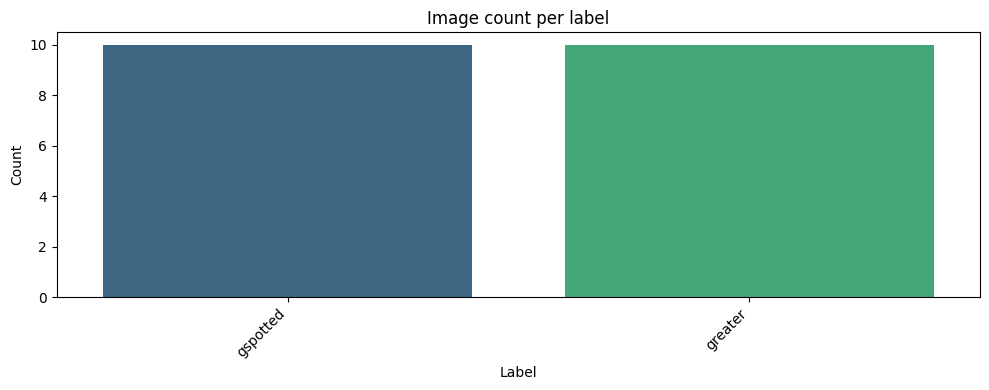

In [8]:
try:
    dataset_df = discover_dataset(IMAGE_DIR)
    display(dataset_df.head())
    summarize_dataset(dataset_df)
except FileNotFoundError as e:
    dataset_df = None
    print(e)
    print("Populate the images directory and rerun this cell when ready.")


## **2. Preprocessing Pipeline**

This section builds TensorFlow `tf.data.Dataset` pipelines with on-the-fly preprocessing and optional augmentation. Adjust the image size or augmentations to suit your dataset.


In [4]:
IMG_SIZE = (224, 224)         # Standard image size for CNNs (e.g., EfficientNet, ResNet)
BATCH_SIZE = 4                # Number of images that are processed at a time
AUTOTUNE = tf.data.AUTOTUNE   # Lets TensorFlow optimize pipeline speed automatically


def load_image(path: tf.Tensor) -> tf.Tensor:
    """Load an image from disk and resize it."""
    image = tf.io.read_file(path)
    image = tf.io.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, IMG_SIZE)
    return image


def build_dataset(
    df: pd.DataFrame,
    class_to_index: Dict[str, int],
    augment: bool = False,
    aggressive_augment: bool = False,
    very_small_dataset: bool = False,
) -> tf.data.Dataset:
    paths = df["path"].astype(str).values
    labels = df["label"].map(class_to_index).values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels)) # constructing a TensorFlow dataset pipeline from dataframe

    def _load_and_preprocess(path, label):
        image = load_image(path)
        if augment:
            image = augment_image(image, aggressive=aggressive_augment, very_small_dataset=very_small_dataset)
        return image, tf.one_hot(label, depth=len(class_to_index))

    ds = ds.shuffle(len(df), seed=SEED)
    ds = ds.map(_load_and_preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds


def augment_image(image: tf.Tensor, aggressive: bool = True, very_small_dataset: bool = False) -> tf.Tensor:
    """
    Apply data augmentation. 
    - aggressive=True: Standard aggressive augmentation
    - very_small_dataset=True: Maximum augmentation for datasets <15 images per class
    """
    # Random flips (always applied)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if very_small_dataset:
        # MAXIMUM augmentation for very small datasets (11 images per class)
        # Color augmentations
        image = tf.image.random_brightness(image, max_delta=0.4)
        image = tf.image.random_contrast(image, 0.6, 1.4)
        image = tf.image.random_saturation(image, 0.5, 1.5)
        image = tf.image.random_hue(image, max_delta=0.15)
        
        # Geometric augmentations
        # Random rotation (90 degree increments)
        image = tf.image.rot90(image, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
        
        # Random zoom via crop and resize
        crop_size = int(IMG_SIZE[0] * tf.random.uniform([], 0.7, 0.95))
        if crop_size > 0:
            image = tf.image.random_crop(image, size=[crop_size, crop_size, 3])
            image = tf.image.resize(image, IMG_SIZE)
        
        # Random translation (shift)
        image = tf.image.random_crop(image, size=[int(IMG_SIZE[0]*0.9), int(IMG_SIZE[1]*0.9), 3])
        image = tf.image.resize(image, IMG_SIZE)
        
    elif aggressive:
        # Standard aggressive augmentation
        image = tf.image.random_brightness(image, max_delta=0.3)
        image = tf.image.random_contrast(image, 0.7, 1.3)
        image = tf.image.random_saturation(image, 0.6, 1.4)
        image = tf.image.random_hue(image, max_delta=0.1)
        # Random rotation (90 degree increments)
        image = tf.image.rot90(image, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
        # Random zoom via crop and resize
        crop_size = int(IMG_SIZE[0] * 0.8)
        if crop_size > 0:
            image = tf.image.random_crop(image, size=[crop_size, crop_size, 3])
            image = tf.image.resize(image, IMG_SIZE)
    else:
        # Mild augmentation
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, 0.9, 1.1)
    
    # Ensure values stay in [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image


def prepare_datasets(df: pd.DataFrame): # splitting the dataset and deciding how much augmentation to apply
    labels = sorted(df["label"].unique())
    class_to_index = {label: idx for idx, label in enumerate(labels)}
    index_to_class = {idx: label for label, idx in class_to_index.items()}

    # Detect dataset size and choose augmentation strategy
    total_images = len(df)
    num_classes = len(labels)
    images_per_class = total_images // num_classes if num_classes > 0 else 0
    
    # Determine augmentation level
    use_very_small_aug = images_per_class < 15  # Maximum augmentation for very small datasets
    use_aggressive_aug = images_per_class < 50 and not use_very_small_aug  # Standard aggressive for small datasets

    train_df, val_df, test_df = train_val_test_split(df)

    train_ds = build_dataset(
        train_df, 
        class_to_index, 
        augment=True, 
        aggressive_augment=use_aggressive_aug,
        very_small_dataset=use_very_small_aug
    )
    val_ds = build_dataset(val_df, class_to_index, augment=False) if len(val_df) else None
    test_ds = build_dataset(test_df, class_to_index, augment=False) if len(test_df) else None

    return {
        "train": train_ds,
        "val": val_ds,
        "test": test_ds,
        "class_to_index": class_to_index,
        "index_to_class": index_to_class,
        "train_df": train_df,
        "val_df": val_df,
        "test_df": test_df,
    }


In [13]:
if dataset_df is not None:
    data_bundle = prepare_datasets(dataset_df)
else:
    data_bundle = None
    print("Dataset not prepared yet. Populate images and rerun.")


⚠️  Very small dataset detected (20 images). Using adjusted splits: 75% train, 15% val, 10% test
Split counts -> train: 14, val: 2, test: 4
